# Lag-Llama Time Series Forecasting

In [25]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 508, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 508 (delta 155), reused 109 (delta 109), pack-reused 312 (from 3)
Receiving objects: 100% (508/508), 286.93 KiB | 5.03 MiB/s, done.
Resolving deltas: 100% (253/253), done.


In [26]:
%cd lag-llama

/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama


In [3]:
%pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /storage/BerlinWeatherTimeSeriesAnalysis/lag-llama

lag-llama.ckpt: 100%|███████████████████████| 29.5M/29.5M [00:00<00:00, 108MB/s]
Download complete. Moving file to /storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt
/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt


In [37]:
from itertools import islice

import pandas as pd
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from torch.serialization import add_safe_globals
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch.distributions.studentT import StudentTOutput
add_safe_globals([NegativeLogLikelihood, StudentTOutput])

Read in Data

In [18]:
# Read in data
years = ["2020", "2021", "2022", "2023", "2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("/storage/BerlinWeatherTimeSeriesAnalysis/data/2019_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"/storage/BerlinWeatherTimeSeriesAnalysis/data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data["Date"] = all_data["ISO Time"].dt.date
all_data["Hour"] = all_data["ISO Time"].dt.hour
hourly_avg = all_data.groupby(["Date", "Hour"]).mean()
hourly_avg

Data Collected


ISO Time  Temperature (C)  Humidity (%)  \
Date       Hour                                                                
2019-01-01 0    2019-01-01 00:29:31.316666624         4.293500    100.000000   
           1    2019-01-01 01:29:31.300000000         4.125000    100.000000   
           2    2019-01-01 02:29:31.300000000         4.056333    100.000000   
           3    2019-01-01 03:29:31.333333248         3.946500    100.000000   
           4    2019-01-01 04:29:31.349999872         3.739667    100.000000   
...                                       ...              ...           ...   
2024-12-31 19   2024-12-31 19:29:31.783333120         3.260667     87.923000   
           20   2024-12-31 20:27:45.234042624         3.269362     86.244255   
           21   2024-12-31 21:30:40.961538560         3.188462     86.157500   
           22   2024-12-31 22:30:33.415094272         3.008491     85.458868   
           23   2024-12-31 23:29:45.310344704         2.883103     85.040517   

                 Pressure (kPa)  Air Quality (Ohms)  
Date       Hour                                      
2019-01-01 0          97.444250        3.253975e+04  
           1          97.446067        3.273012e+04  
           2          97.384150        3.299228e+04  
           3          97.308767        3.124677e+04  
           4          97.258917        3.359688e+04  
...                         ...                 ...  
2024-12-31 19        101.286583        1.069465e+06  
           20        101.242021        1.062867e+06  
           21        101.193154        1.044766e+06  
           22        101.163792        1.117850e+06  
           23        101.073000        1.031384e+06  

[51931 rows x 5 columns]

In [45]:
data = hourly_avg["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
data = data.reset_index()
data['datetime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
data = data.set_index('datetime')
data.drop(columns=["Date", "Hour"], inplace=True)
data

,Temperature (C)
datetime,
2019-01-01 00:00:00,4.293500
2019-01-01 01:00:00,4.125000
2019-01-01 02:00:00,4.056333
2019-01-01 03:00:00,3.946500
2019-01-01 04:00:00,3.739667
...,...
2024-12-31 19:00:00,3.260667
2024-12-31 20:00:00,3.269362
2024-12-31 21:00:00,3.188462


<Figure size 1400x500 with 0 Axes>

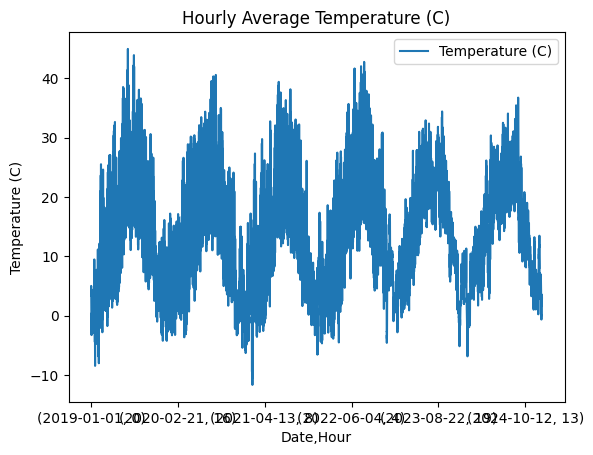

In [46]:
plt.figure(figsize=(14, 5))
hourly_avg.plot(y="Temperature (C)")
plt.title(f"Hourly Average Temperature (C)")
plt.ylabel("Temperature (C)")
plt.show()

## Model Setup

In [47]:
prediction_length = 24  # Predict one day ahead
context_length = prediction_length * 7 # One week context 
num_samples = 20
device = "cuda"
batch_size = 64

In [48]:
ckpt_path = "/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt"
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

zs_estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length,
    device=torch.device(device),

    # estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],
    
    nonnegative_pred_samples=True,

    # Linear Positional Encoding Scaling
    rope_scaling={
        "type":"linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },

    batch_size=batch_size,
    num_parallel_samples=num_samples
)


zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

Zero-Shot Prediction

In [56]:
valid_end = round(len(data) * 0.9)
date_list = pd.date_range(data[valid_end:].index[2] + pd.Timedelta(hours=6), periods=6, freq="1d").tolist()

zs_forecasts = []
zs_tss = []

for d in date_list:
  print(d)
  # Slice and Sanitize
  sliced = data[:d]
  sliced = sliced.asfreq("1H")  # Force to hourly frequency
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback
  
  # Forecast
  forecast_it, ts_it = make_evaluation_predictions(
          dataset=PandasDataset(sliced, freq="1h", target="Temperature (C)"),
          predictor=zs_predictor,
          num_samples=num_samples
  )
  zs_forecasts.append(list(forecast_it))
  zs_tss.append(list(ts_it))

2024-05-29 21:00:00


/tmp/ipykernel_1457/2368516208.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback


2024-05-30 21:00:00


/tmp/ipykernel_1457/2368516208.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback


2024-05-31 21:00:00


/tmp/ipykernel_1457/2368516208.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback


2024-06-01 21:00:00


/tmp/ipykernel_1457/2368516208.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback


2024-06-02 21:00:00


/tmp/ipykernel_1457/2368516208.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback


2024-06-03 21:00:00


/tmp/ipykernel_1457/2368516208.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sliced = sliced.fillna(method='ffill').fillna(method='bfill').astype("float32")  # Fill NAs forward, then backward as fallback


Evaluation

In [ ]:

evaluator = Evaluator()
zs_a_metrics = [] # aggregated forecast metrics, we'll use the MAPE metric to evaluate
zs_t_metrics = [] # information about each time series, we'll use this to graph

for (t,s) in zip(zs_tss, zs_forecasts):
  agg_metrics, ts_metrics = evaluator(t, s)
  zs_a_metrics.append(agg_metrics)
  zs_t_metrics.append(ts_metrics)

TypeError: Evaluator.__init__() got an unexpected keyword argument 'calculation_params'

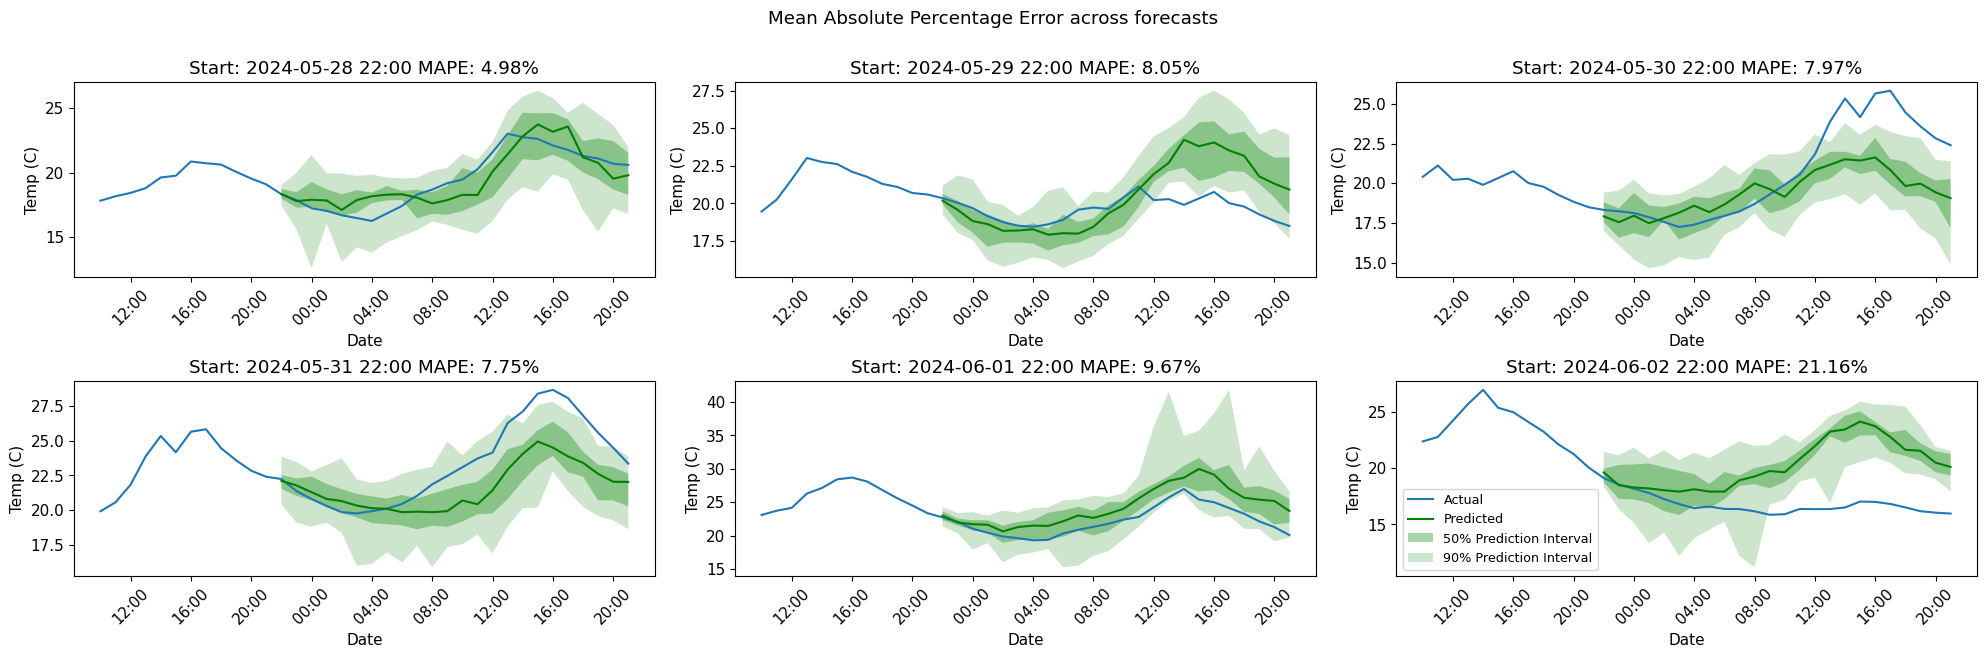

In [65]:

plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M') #%b %d \'%y %H')


for idx in range(len(zs_forecasts)):
  ax = plt.subplot(3, 3, idx+1)
  t = zs_tss[idx][0][zs_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(hours=12):]
  
  smape = float(f'{zs_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
  smape = float(f'{smape:.2f}')
  ax.set_title("Start: " + str(zs_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
  plt.plot(t.index.to_timestamp(), t[0])
  ax.xaxis.set_major_formatter(date_formater)
  #ax.set_ticks()
  #ax.set_xticklabels(fontsize="small") #["Day " + str(i + 1) for i in range(7)], fontsize="small")
  ax.set_xlabel('Date')
  ax.set_ylabel('Temp (C)')
  zs_forecasts[idx][0].plot(color='g')
  plt.xticks(rotation=45)

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.legend(["Actual", "Predicted",'50% Prediction Interval', '90% Prediction Interval'], fontsize="small")
plt.show()